In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# for reproducible results
random.seed(42)
np.random.seed(42)

In [26]:
# Maze definition
maze = [
    ['S', ' ', ' ', 'G'],
    [' ', '#', ' ', '#'],
    [' ', ' ', ' ', ' '],
]

# Convert maze to a more usable format
maze_np = np.array(maze)
rows, cols = maze_np.shape

# Define rewards
rewards = {
    'G': 10,   # Reward for reaching the goal
    '#': -10,  # Penalty for hitting a wall (shouldn't happen with optimal policy)
    ' ': -0.1, # Cost for each step in an empty space
    'S': -0.1  # Cost for starting or stepping in S
}

# Define actions (Up, Down, Left, Right)
# (row_change, col_change)
actions = {
    'UP': (-1, 0),
    'DOWN': (1, 0),
    'LEFT': (0, -1),
    'RIGHT': (0, 1)
}
action_names = list(actions.keys())

# Find start and goal states
start_state = None
goal_state = None
for r in range(rows):
    for c in range(cols):
        if maze_np[r, c] == 'S':
            start_state = (r, c)
        elif maze_np[r, c] == 'G':
            goal_state = (r, c)

print(f"Maze Layout:\n{maze_np}")
print(f"Start State: {start_state}, Goal State: {goal_state}")
print(f"Actions: {action_names}")
print(f"Rewards for G, #, ' ': {rewards['G']}, {rewards['#']}, {rewards[' ']}\n")

# Helper function to get next state and reward
def get_next_state_and_reward(state, action_name):
    """
    Simulates taking an action from a state.
    Returns (next_state, reward).
    If the action leads to a wall or out of bounds, the agent stays in the current state
    and receives a wall penalty.
    """
    action_coords = actions[action_name]
    next_r, next_c = state[0] + action_coords[0], state[1] + action_coords[1]

    # Check for boundaries
    if not (0 <= next_r < rows and 0 <= next_c < cols):
        # Out of bounds, stay in current state, get wall penalty
        return state, rewards['#']

    cell_type = maze_np[next_r, next_c]

    if cell_type == '#':
        # Hit a wall, stay in current state, get wall penalty
        return state, rewards['#']
    else:
        # Valid move
        current_reward = rewards.get(cell_type, 0) # Reward for landing on G, or step cost
        return (next_r, next_c), current_reward

Maze Layout:
[['S' ' ' ' ' 'G']
 [' ' '#' ' ' '#']
 [' ' ' ' ' ' ' ']]
Start State: (0, 0), Goal State: (0, 3)
Actions: ['UP', 'DOWN', 'LEFT', 'RIGHT']
Rewards for G, #, ' ': 10, -10, -0.1



# Opdracht A - Temporal difference learning

In [27]:
# Define the optimal policy pi_star
pi_star = {
    (0, 0): 'RIGHT',
    (0, 1): 'RIGHT',
    (0, 2): 'RIGHT',
    (1, 0): 'UP',
    (1, 2): 'UP',

    (2, 0): 'UP',
    (2, 1): 'UP',
    (2, 2): 'LEFT',
    (2, 3): 'LEFT',
}

# A more robust optimal policy (manually defined for this example):
pi_star = {
    (0, 0): 'RIGHT',
    (0, 1): 'RIGHT',
    (0, 2): 'RIGHT',
    (1, 0): 'UP',
    (1, 2): 'UP',
    (2, 0): 'UP',
    (2, 1): 'LEFT',
    (2, 2): 'UP',
    (2, 3): 'LEFT',
}

# Add goal state to pi_star for completeness, though it won't be used for action selection
if goal_state:
    pi_star[goal_state] = 'TERMINAL'

print("Optimal Policy (pi_star):")
for r in range(rows):
    row_str = []
    for c in range(cols):
        state = (r, c)
        if maze_np[r,c] == '#':
            row_str.append("  WALL  ")
        elif state == goal_state:
            row_str.append("  GOAL  ")
        else:
            action = pi_star.get(state, "  ---  ") # Default if state not in policy (shouldn't happen for reachable states)
            row_str.append(f"{action:^8}")
    print(" | ".join(row_str))
print("\n")

Optimal Policy (pi_star):
 RIGHT   |  RIGHT   |  RIGHT   |   GOAL  
   UP    |   WALL   |    UP    |   WALL  
   UP    |   LEFT   |    UP    |   LEFT  




In [28]:
def td_0_evaluation(maze_np, pi_star, goal_state, start_state_initial,
                    gamma, alpha, num_episodes):
    """
    Performs TD(0) policy evaluation.

    Args:
        maze_np (np.array): The maze.
        pi_star (dict): The policy to evaluate {state: action_name}.
        goal_state (tuple): Coordinates of the goal state.
        start_state_initial (tuple): The initial state for each episode.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        num_episodes (int): Number of episodes to run.

    Returns:
        V (dict): The learned value function {state: value}.
        V_history (list): History of V values for convergence plotting.
        td_errors_history (list): History of TD errors for specific states.
    """
    V = {} # Initialize V(s) for all states s
    for r in range(maze_np.shape[0]):
        for c in range(maze_np.shape[1]):
            if maze_np[r, c] != '#': # Walls don't have values in this context
                V[(r, c)] = 0.0

    if goal_state: # V(terminal) = 0
        V[goal_state] = 0.0

    V_history = [] # To track changes in V for convergence plot
    # td_errors_history = {s: [] for s in V if s != goal_state} # Track TD error for some states

    for episode in range(num_episodes):
        S = start_state_initial # Initialize S for the episode

        # Store a copy of V at the beginning of the episode for convergence tracking
        V_copy_episode_start = {k:v for k,v in V.items()}

        while True:
            if S == goal_state: # Episode ends if S is terminal
                break

            action_S = pi_star.get(S)
            if action_S is None or action_S == 'TERMINAL': # Should not happen for non-terminal S if pi_star is complete
                print(f"Warning: No action in pi_star for non-terminal state {S} or action is TERMINAL. Breaking episode.")
                break

            S_prime, R = get_next_state_and_reward(S, action_S)

            # TD Update
            td_target = R + gamma * V.get(S_prime, 0.0) # V.get(S_prime, 0.0) handles if S_prime is new or wall
            td_error = td_target - V.get(S, 0.0)
            V[S] = V.get(S, 0.0) + alpha * td_error

            # if S in td_errors_history:
            #     td_errors_history[S].append(abs(td_error))

            S = S_prime # Move to the next state

        # After each episode, record the sum of absolute differences in V for convergence
        current_V_values = np.array(list(V_copy_episode_start.values()))
        next_V_values = np.array(list(V.values()))
        if len(current_V_values) == len(next_V_values): # Ensure same states are compared
            V_history.append(sum(abs(v_val - V_copy_episode_start.get(k, 0.0)) for k, v_val in V.items()))


    return V, V_history #, td_errors_history

In [29]:
def plot_value_function(V, title="Value Function Heatmap"):
    """Plots the value function as a heatmap on the maze."""
    rows, cols = maze_np.shape
    value_grid = np.full((rows, cols), np.nan) # Use NaN for walls or unvisited states initially

    for r in range(rows):
        for c in range(cols):
            if maze_np[r,c] != '#':
                value_grid[r,c] = V.get((r,c), 0) # Default to 0 if state not in V (e.g. unreachables)

    plt.figure(figsize=(cols + 1, rows + 1))
    sns.heatmap(value_grid, annot=True, fmt=".2f", cmap="viridis", cbar=True,
                linewidths=.5, linecolor='black', annot_kws={"size": 10})

    # Overlay maze structure (S, G, #)
    for r in range(rows):
        for c in range(cols):
            text = maze_np[r,c]
            if text == 'S' or text == 'G':
                 plt.text(c + 0.5, r + 0.5, text,
                         ha="center", va="center", color="red", weight="bold", fontsize=12)
            elif text == '#':
                 plt.text(c + 0.5, r + 0.5, text,
                         ha="center", va="center", color="white", weight="bold", fontsize=12)


    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_convergence(V_history, title="Convergence of V-values (Sum of Absolute Changes)"):
    """Plots the sum of absolute changes in V values per episode."""
    plt.figure(figsize=(10, 5))
    plt.plot(V_history)
    plt.xlabel("Episode")
    plt.ylabel("Sum of Abs. Changes in V from prev. episode")
    plt.title(title)
    plt.grid(True)
    plt.show()


--- Running TD(0) for gamma = 1.0 ---

Learned Value Function (V) for gamma = 1.0:
V(0, 0) = 9.80 | V(0, 1) = 9.90 | V(0, 2) = 10.00 | V(0, 3) = 0.00 | 
V(1, 0) = 0.00 | V(1, 2) = 0.00 | 
V(2, 0) = 0.00 | V(2, 1) = 0.00 | V(2, 2) = 0.00 | V(2, 3) = 0.00 | 


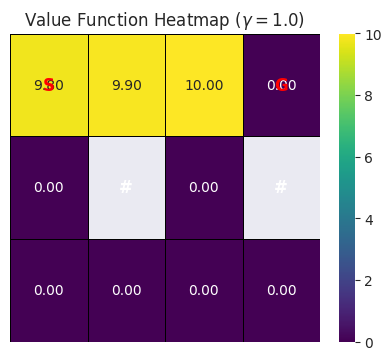

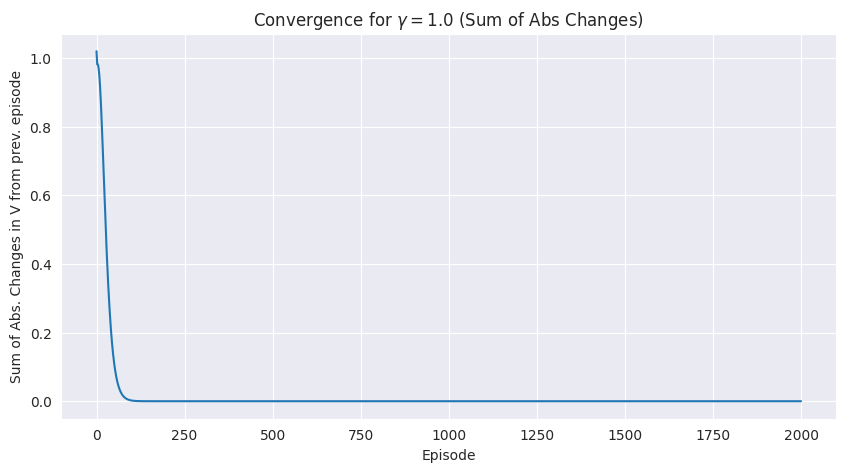

In [30]:
# Parameters for gamma = 1.0
gamma_1 = 1.0
alpha_1 = 0.1  # Learning rate
num_episodes_1 = 2000 # Number of episodes

print(f"--- Running TD(0) for gamma = {gamma_1} ---")
V_gamma1, V_history_gamma1 = td_0_evaluation(
    maze_np, pi_star, goal_state, start_state,
    gamma_1, alpha_1, num_episodes_1
)

print("\nLearned Value Function (V) for gamma = 1.0:")
for r in range(rows):
    for c in range(cols):
        state = (r,c)
        if maze_np[r,c] != '#':
            print(f"V{state} = {V_gamma1.get(state, 0.0):.2f}", end=" | ")
    print()

plot_value_function(V_gamma1, title=rf"Value Function Heatmap ($\gamma = {gamma_1}$)")
plot_convergence(V_history_gamma1, title=rf"Convergence for $\gamma = {gamma_1}$ (Sum of Abs Changes)")

#  Results voor γ=1.0

Ik heb de beste policy π∗ bekeken met TD(0) met γ=1,0, een learningrate van α=0,1, stepcost van −0,1 en een goalreward van +10. V(G) was vast op 0.
### 1. Waardefunctieanalyse
- Waargenomen waarden:
    - V(0,0)(‘S’): 9,80
    - V(0,1): 9,90
    - V(0,2): 10,00
    - V(0,3)(‘G’): 0,00
    - Andere states (bijv. V(1,0), V(2,0)) bleven 0,00.
### 2. Interpretatie:
- De waarden voor de states (0,0) tot en met (0,2) geven de verwachte totale un-discounted reward goed weer. Bijvoorbeeld, V(0,2)≈10,00 (de goal reward, aangezien V(G)=0), V(0,1)≈−0,1+V(0,2)=9,90 en V(0,0)≈−0,1+V(0,1)=9,80.
- De heatmap laat dit goed zien, met waarden die toenemen langs het directe pad naar het doel.
- States die niet op het directe pad van ‘S’ (0,0) liggen, bleven op 0,00. Dit komt omdat episodes begonnen bij ‘S’ en het deterministische policy π∗ volgden, zodat deze andere states niet werden bezocht en hun waarden niet werden bijgewerkt vanaf hun oorspronkelijke nulwaarde.


--- Running TD(0) for gamma = 0.5 ---

Learned Value Function (V) for gamma = 0.5:
V(0, 0) = 2.35 | V(0, 1) = 4.90 | V(0, 2) = 10.00 | V(0, 3) = 0.00 | 
V(1, 0) = 0.00 | V(1, 2) = 0.00 | 
V(2, 0) = 0.00 | V(2, 1) = 0.00 | V(2, 2) = 0.00 | V(2, 3) = 0.00 | 


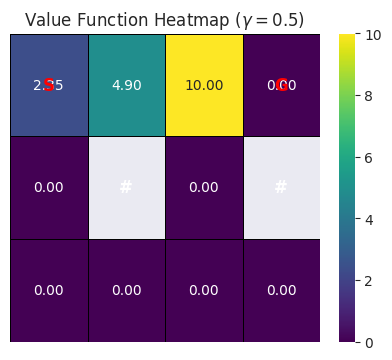

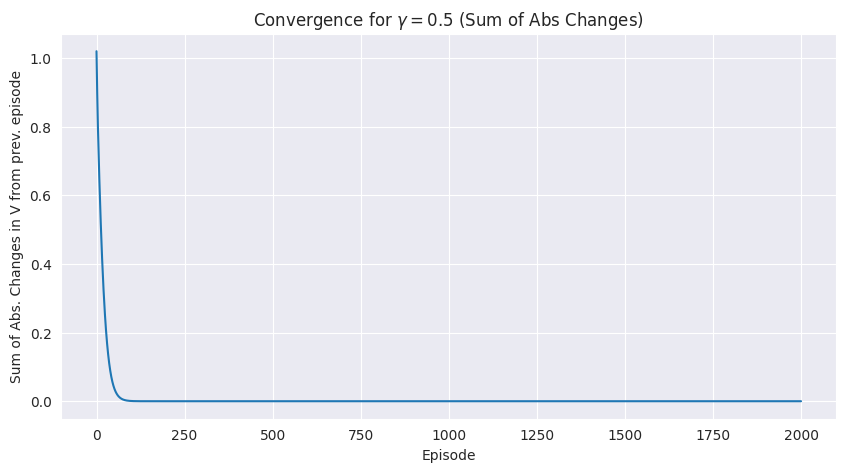

In [31]:
# Parameters for gamma = 0.5
gamma_2 = 0.5
alpha_2 = 0.1  # Learning rate (can be same or different)
num_episodes_2 = 2000 # Number of episodes

print(f"\n--- Running TD(0) for gamma = {gamma_2} ---")
V_gamma0_5, V_history_gamma0_5 = td_0_evaluation(
    maze_np, pi_star, goal_state, start_state,
    gamma_2, alpha_2, num_episodes_2
)

print("\nLearned Value Function (V) for gamma = 0.5:")
for r in range(rows):
    for c in range(cols):
        state = (r,c)
        if maze_np[r,c] != '#':
            print(f"V{state} = {V_gamma0_5.get(state, 0.0):.2f}", end=" | ")
    print()

plot_value_function(V_gamma0_5, title=rf"Value Function Heatmap ($\gamma = {gamma_2}$)")
plot_convergence(V_history_gamma0_5, title=rf"Convergence for $\gamma = {gamma_2}$ (Sum of Abs Changes)")


#  Results voor γ=0.5
Met γ=0,5 (andere dingen hetzelfde):
### 1. Waardefunctie (γ=0,5):
- V(0,0) (‘S’): 2,35, V(0,1): 4,90, V(0,2): 10,00. Andere dingen bleven 0,00.
- Deze waarden kloppen: V(0,2)≈10 (reward voor direct doel), V(0,1)≈−0,1+0,5×V(0,2)=4,90 en V(0,0)≈−0,1+0,5×V(0,1)=2,35.
### 2. Belangrijkste verschillen met γ=1,0:
- Lagere waarden: States die verder van het doel verwijderd zijn, hebben aanzienlijk lagere waarden met γ=0,5 (bijvoorbeeld V(S) is 2,35 tegenover 9,80 voor γ=1,0). Dit komt doordat de waarde van toekomstige rewards (zoals V(0,2)) bij elke stap terug wordt gehalveerd bij het berekenen van de waarden van voorgaande states.
- Steilere helling: De waarde daalt veel sneller als je verder van het doel afgaat met γ=0,5, wat een ‘kortzichtige’ beoordeling laat zien waarbij rewards die nog ver weg zijn flink minder waard worden.
### 3. Convergentie (γ=0,5):
- De convergentiegrafiek liet een snelle stabilisatie zien, net als bij γ=1,0, wat aangeeft dat states die al bezocht zijn efficiënt worden geleerd.

In het kort zorgt γ=0,5 voor tot een evaluatie die voorrang geeft aan onmiddellijke rewards, wat resulteert in lagere state values voor states die niet onmiddellijk voorafgaan aan grote rewards, in vergelijking met de ‘vooruitziende’ γ=1,0-evaluatie.


# Opdracht B: SARSA

In [32]:
# Initialize Q-table
def initialize_q_table(rows, cols, action_names, maze_np, goal_state):
    Q = {}
    for r in range(rows):
        for c in range(cols):
            state = (r, c)
            if maze_np[r,c] != '#': # Walls don't have Q-values directly
                Q[state] = {action: 0.0 for action in action_names}
                if state == goal_state: # Q(terminal, .) = 0
                    Q[state] = {action: 0.0 for action in action_names} # Explicitly ensure terminal Q is 0
    return Q

# Epsilon-greedy policy
def epsilon_greedy_policy(Q_s, epsilon, action_names_list):
    """
    Chooses an action based on epsilon-greedy policy for a given state S.
    Q_s is Q[S] = {action: value}.
    """
    if random.random() < epsilon:
        return random.choice(action_names_list)
    else:
        # Find action with max Q-value. Break ties randomly.
        max_q = -float('inf')
        best_actions = []
        for action, q_val in Q_s.items():
            if q_val > max_q:
                max_q = q_val
                best_actions = [action]
            elif q_val == max_q:
                best_actions.append(action)
        return random.choice(best_actions) if best_actions else random.choice(action_names_list)


# SARSA Algorithm
def sarsa_control(maze_np, start_state_initial, goal_state,
                  gamma, alpha, epsilon, num_episodes, max_steps_per_episode=100):
    """
    Performs SARSA control to learn Q-values and an optimal policy.
    """
    rows, cols = maze_np.shape
    Q = initialize_q_table(rows, cols, action_names, maze_np, goal_state)

    episode_rewards = [] # To track rewards per episode for convergence

    for episode in range(num_episodes):
        S = start_state_initial
        # Ensure Q[S] exists before calling epsilon_greedy_policy
        if S not in Q:
            Q[S] = {action: 0.0 for action in action_names}

        A = epsilon_greedy_policy(Q[S], epsilon, action_names)

        current_episode_reward = 0

        for step in range(max_steps_per_episode):
            if S == goal_state: # Episode ends if S is terminal
                break

            S_prime, R = get_next_state_and_reward(S, A)
            current_episode_reward += R

            A_prime = None
            if S_prime == goal_state:
                q_s_prime_a_prime = 0.0
            else:
                # Ensure Q[S_prime] exists
                if S_prime not in Q: # If S_prime is a new state (e.g., explored into a wall and stayed)
                    if maze_np[S_prime] != '#': # only if not a wall state itself
                        Q[S_prime] = {action: 0.0 for action in action_names}
                    else:
                        print(f"Error: S_prime {S_prime} is a wall, but Q table access attempted.")

                A_prime = epsilon_greedy_policy(Q[S_prime], epsilon, action_names)
                q_s_prime_a_prime = Q[S_prime][A_prime]

            # SARSA Update
            td_target = R + gamma * q_s_prime_a_prime
            td_error = td_target - Q[S][A]
            Q[S][A] = Q[S][A] + alpha * td_error

            S = S_prime
            A = A_prime # A becomes A_prime for the next iteration

            if A is None and S != goal_state :
                print(f"Warning: A_prime became None for non-terminal state S_prime={S_prime}. Episode {episode}, step {step}")
                break

        episode_rewards.append(current_episode_reward)
        if (episode + 1) % (num_episodes // 10) == 0: # Print progress
             print(f"Episode {episode + 1}/{num_episodes} completed. Avg reward (last 10%): {np.mean(episode_rewards[-max(1, num_episodes // 10):]):.2f}")


    # Derive final policy from Q-table (greedy policy)
    final_policy = {}
    V_star = {} # To store max_a Q(s,a) for visualization
    for r_idx in range(rows):
        for c_idx in range(cols):
            state = (r_idx, c_idx)
            if maze_np[state] != '#' and state != goal_state:
                if state in Q and Q[state]: # Check if state and its actions are in Q
                    # For epsilon_greedy with epsilon=0 (greedy action)
                    best_action = epsilon_greedy_policy(Q[state], 0, action_names)
                    final_policy[state] = best_action
                    V_star[state] = Q[state][best_action] # or simply max(Q[state].values())
                else:
                    final_policy[state] = "---"
                    V_star[state] = 0 # Or NaN
            elif state == goal_state:
                final_policy[state] = "GOAL"
                V_star[state] = 0 # V(terminal) = 0

    return Q, final_policy, episode_rewards, V_star

In [33]:
def plot_sarsa_policy(policy_dict, title="Learned Policy (SARSA)"):
    """Plots the learned policy as arrows on the maze."""
    rows, cols = maze_np.shape
    plt.figure(figsize=(cols + 1, rows + 1))

    action_to_arrow = {
        'UP': u'$\u2191$', 'DOWN': u'$\u2193$',
        'LEFT': u'$\u2190$', 'RIGHT': u'$\u2192$',
        '---': '', 'GOAL': 'G'
    }

    for r in range(rows):
        for c in range(cols):
            state = (r, c)
            if maze_np[r,c] == '#':
                plt.text(c, r, '#', ha="center", va="center", color="black", weight="bold", fontsize=15)
            elif state == start_state:
                 plt.text(c, r, 'S', ha="center", va="center", color="blue", weight="bold", fontsize=15)
                 arrow = action_to_arrow.get(policy_dict.get(state, ''), '')
                 plt.text(c, r+0.1, arrow, ha="center", va="top", color="green", fontsize=20) # Show action from S
            elif state == goal_state:
                plt.text(c, r, 'G', ha="center", va="center", color="red", weight="bold", fontsize=15)
            else:
                action = policy_dict.get(state, '')
                arrow = action_to_arrow.get(action, '')
                plt.text(c, r, arrow, ha="center", va="center", color="green", fontsize=20)

    plt.title(title)
    plt.xticks(np.arange(cols))
    plt.yticks(np.arange(rows))
    plt.gca().invert_yaxis() # To match maze array indexing (0,0 at top-left)
    plt.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.5)
    plt.show()

def plot_sarsa_value_function(V_star_dict, title="State-Value Function V(s) from max_a Q(s,a)"):
    """Plots V(s) = max_a Q(s,a) as a heatmap."""
    rows, cols = maze_np.shape
    value_grid = np.full((rows, cols), np.nan)

    for r in range(rows):
        for c in range(cols):
            state = (r,c)
            if maze_np[r,c] != '#':
                value_grid[r,c] = V_star_dict.get(state, 0) # Default to 0 if state not in V_star

    plt.figure(figsize=(cols + 1, rows + 1))
    sns.heatmap(value_grid, annot=True, fmt=".2f", cmap="viridis", cbar=True,
                linewidths=.5, linecolor='black', annot_kws={"size": 10})
    for r_idx in range(rows): # Overlay S, G, #
        for c_idx in range(cols):
            text = maze_np[r_idx,c_idx]
            if text == 'S' or text == 'G':
                 plt.text(c_idx + 0.5, r_idx + 0.5, text,
                         ha="center", va="center", color="red", weight="bold", fontsize=12)
            elif text == '#':
                 plt.text(c_idx + 0.5, r_idx + 0.5, '#', # Show # for walls
                         ha="center", va="center", color="white", weight="bold", fontsize=12)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_episode_rewards(episode_rewards_list, title="Total Reward per Episode"):
    """Plots the total reward obtained in each episode."""
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards_list)
    if len(episode_rewards_list) >= 100:
        moving_avg = np.convolve(episode_rewards_list, np.ones(100)/100, mode='valid')
        plt.plot(np.arange(99, len(episode_rewards_list)), moving_avg, label='100-episode MA')
        plt.legend()
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.grid(True)
    plt.show()

--- Running SARSA for gamma = 1.0 ---
Episode 500/5000 completed. Avg reward (last 10%): 7.99
Episode 1000/5000 completed. Avg reward (last 10%): 8.48
Episode 1500/5000 completed. Avg reward (last 10%): 8.26
Episode 2000/5000 completed. Avg reward (last 10%): 8.63
Episode 2500/5000 completed. Avg reward (last 10%): 8.13
Episode 3000/5000 completed. Avg reward (last 10%): 8.19
Episode 3500/5000 completed. Avg reward (last 10%): 8.43
Episode 4000/5000 completed. Avg reward (last 10%): 8.62
Episode 4500/5000 completed. Avg reward (last 10%): 8.25
Episode 5000/5000 completed. Avg reward (last 10%): 8.48


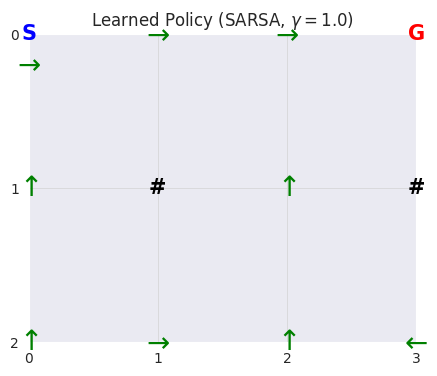

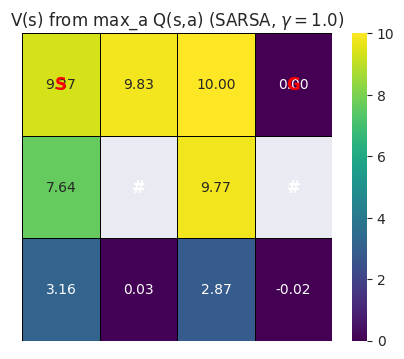

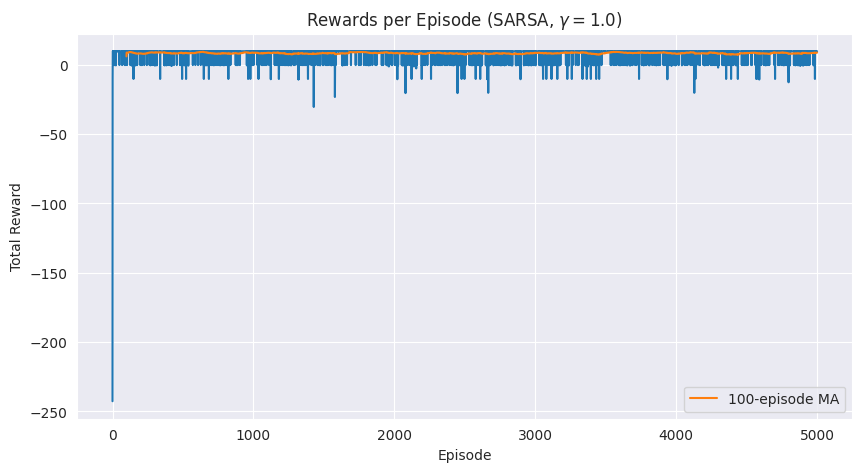

In [34]:
# Parameters for SARSA with gamma = 1.0
sarsa_gamma_1 = 1.0
sarsa_alpha_1 = 0.1
sarsa_epsilon_1 = 0.1
sarsa_num_episodes_1 = 5000
sarsa_max_steps_1 = 200

print(f"--- Running SARSA for gamma = {sarsa_gamma_1} ---")
Q_sarsa1, policy_sarsa1, rewards_sarsa1, V_sarsa1 = sarsa_control(
    maze_np, start_state, goal_state,
    sarsa_gamma_1, sarsa_alpha_1, sarsa_epsilon_1, sarsa_num_episodes_1, sarsa_max_steps_1
)

plot_sarsa_policy(policy_sarsa1, title=rf"Learned Policy (SARSA, $\gamma={sarsa_gamma_1}$)")
plot_sarsa_value_function(V_sarsa1, title=rf"V(s) from max_a Q(s,a) (SARSA, $\gamma={sarsa_gamma_1}$)")
plot_episode_rewards(rewards_sarsa1, title=rf"Rewards per Episode (SARSA, $\gamma={sarsa_gamma_1}$)")


# Results voor y=1
### 1. Learned Policy & State Values  (V(s)=maxa​Q(s,a)):
- De policyplot laat zien dat de agent effectieve routes naar het doel ‘G’ heeft geleerd vanuit alle bereikbare delen van het doolhof, waarbij hij met succes om muren heen navigeert.
- De V(s) heatmap laat zien hoe de waarden stijgen naarmate de states dichter bij ‘G’ komen. Bijvoorbeeld, V(0,2) (naast ‘G’) is 10,00, V(0,1) is 9,83 en V(S) (0,0) is 9,57. Deze waarden liggen dicht bij de theoretische totale un-discounted rewards (bijvoorbeeld 10-staps kosten), met kleine verschillen die te verklaren zijn door het on-policy karakter van SARSA, dat een ϵ-greedy strategie leert. Belangrijk is dat door de verkenning alle bereikbare states zinvolle waarde-updates hebben gekregen, in tegenstelling tot de TD(0)-evaluatie met een vaste start.

### 2. Rewards per episode:
- De rewardsgrafiek laat een duidelijke leertrend zien: de aanvankelijk lage/negatieve rewards verbeterden snel en het voortschrijdend gemiddelde over 100 episodes stabiliseerde zich.
- De gemiddelde totale rewards in latere episodes (ongeveer 8,1-8,6) is positief en aanzienlijk, hoewel iets minder dan de rewards van het optimale pad (9,8). Dit verschil is te verwachten vanwege de voortdurende ϵ=0,1-verkenning, waarbij 10% van de acties willekeurig is en tot suboptimale stappen kan leiden.

### 3. Conclusie voor SARSA (γ=1,0):
 - SARSA heeft effectief een bijna-optimaal policy geleerd om het doel te bereiken. De geleerde Q-waarden en de afgeleide V(s)-kaart weerspiegelen het doel om de totale un-discounted rewards te maximaliseren. De prestaties van de agent, weergegeven door de rewards per episode, zijn aanzienlijk verbeterd en gestabiliseerd, wat aantoont dat de on-policy-controle succesvol is ondanks voortdurende verkenning.


--- Running SARSA for gamma = 0.9 ---
Episode 500/5000 completed. Avg reward (last 10%): 7.75
Episode 1000/5000 completed. Avg reward (last 10%): 7.80
Episode 1500/5000 completed. Avg reward (last 10%): 8.54
Episode 2000/5000 completed. Avg reward (last 10%): 8.44
Episode 2500/5000 completed. Avg reward (last 10%): 8.28
Episode 3000/5000 completed. Avg reward (last 10%): 8.26
Episode 3500/5000 completed. Avg reward (last 10%): 8.42
Episode 4000/5000 completed. Avg reward (last 10%): 8.08
Episode 4500/5000 completed. Avg reward (last 10%): 8.39
Episode 5000/5000 completed. Avg reward (last 10%): 8.24


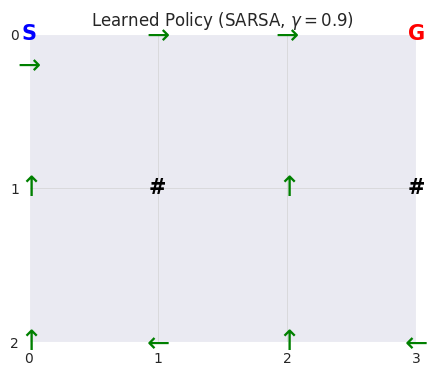

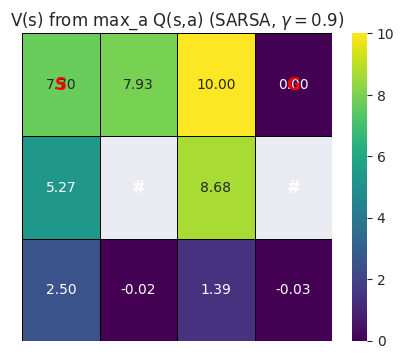

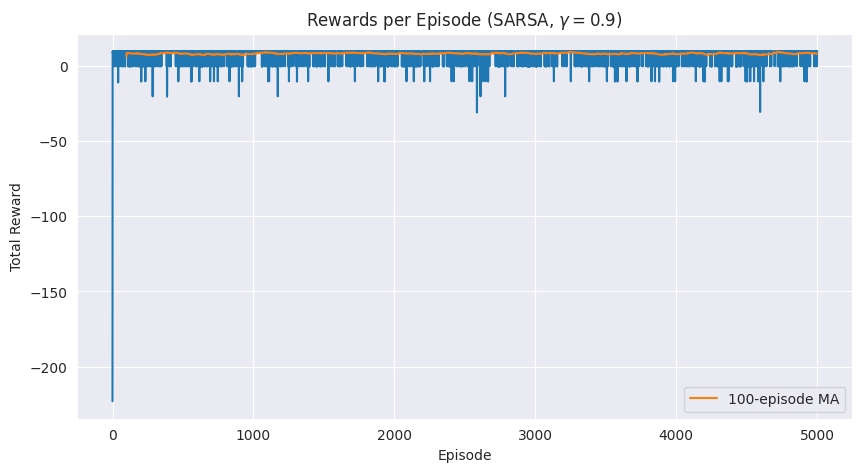

In [35]:
# Parameters for SARSA with gamma = 0.9
sarsa_gamma_2 = 0.9
sarsa_alpha_2 = 0.1
sarsa_epsilon_2 = 0.1
sarsa_num_episodes_2 = 5000
sarsa_max_steps_2 = 200

print(f"\n--- Running SARSA for gamma = {sarsa_gamma_2} ---")
Q_sarsa2, policy_sarsa2, rewards_sarsa2, V_sarsa2 = sarsa_control(
    maze_np, start_state, goal_state,
    sarsa_gamma_2, sarsa_alpha_2, sarsa_epsilon_2, sarsa_num_episodes_2, sarsa_max_steps_2
)

plot_sarsa_policy(policy_sarsa2, title=rf"Learned Policy (SARSA, $\gamma={sarsa_gamma_2}$)")
plot_sarsa_value_function(V_sarsa2, title=rf"V(s) from max_a Q(s,a) (SARSA, $\gamma={sarsa_gamma_2}$)")
plot_episode_rewards(rewards_sarsa2, title=rf"Rewards per Episode (SARSA, $\gamma={sarsa_gamma_2}$)")

# Results voor y=0.9
### 1. Learned Policy & State Values :
- De Policy dat met γ=0,9 is geleerd, zag er bijna hetzelfde uit als dat met γ=1,0 en leidde de agent vanuit alle situaties goed naar het doel.
- V(0,2) (naast het doel) bleef 10,00, net als met γ=1,0.
- De waarden voor statussen die verder van het doel verwijderd waren, waren echter aanzienlijk lager met γ=0,9 (bijvoorbeeld V(S) was 7,50 tegenover 9,57 voor γ=1,0). Dit laat zien dat het kortetermijndenken dat ontstaat door toekomstige rewards te discounten, ervoor zorgt dat de waarden sneller dalen.

### 2. Rewards per episode:
- De gemiddelde daadwerkelijke reward die per aflevering werden verzameld (ongeveer 8,24) waren vergelijkbaar met het geval γ=1,0 (ongeveer 8,48), aangezien de fysieke paden die door de vergelijkbare beleidsregels werden gevolgd grotendeels hetzelfde waren.


3. Conclusie voor SARSA (γ=0,9):
 - SARSA leerde goed met γ=0,9. Het belangrijkste effect van discount (van 1,0 naar 0,9) was een vermindering van de geleerde state values voor states die verder van het doel verwijderd waren, in plaats van een significante verandering in de optimale policy of de daadwerkelijk verzamelde rewards per episode in dit doolhof.

# Opdracht C: Q-learning

In [39]:
def q_learning_control(maze_np, start_state_initial, goal_state, action_names_list,
                       gamma, alpha, epsilon, num_episodes, max_steps_per_episode=100):
    rows, cols = maze_np.shape
    Q = initialize_q_table(rows, cols, action_names_list, maze_np, goal_state)

    episode_rewards = []

    for episode in range(num_episodes):
        S = start_state_initial
        current_episode_reward = 0

        for step in range(max_steps_per_episode):
            if S == goal_state:
                break

            if S not in Q:
                 Q[S] = {action: 0.0 for action in action_names_list}
            A = epsilon_greedy_policy(Q[S], epsilon, action_names_list)

            S_prime, R = get_next_state_and_reward(S, A)
            current_episode_reward += R

            if S_prime == goal_state:
                max_q_s_prime_a_prime = 0.0
            else:
                if S_prime not in Q:
                    Q[S_prime] = {action: 0.0 for action in action_names_list}

                max_q_s_prime_a_prime = -float('inf')
                if Q[S_prime]:
                    max_q_s_prime_a_prime = max(Q[S_prime].values())
                else:
                    max_q_s_prime_a_prime = 0.0

            td_target = R + gamma * max_q_s_prime_a_prime
            td_error = td_target - Q[S][A]
            Q[S][A] = Q[S][A] + alpha * td_error
            S = S_prime

        episode_rewards.append(current_episode_reward)
        if (episode + 1) % (num_episodes // 10) == 0:
             print(f"Episode {episode + 1}/{num_episodes} completed. Avg reward (last 10%): {np.mean(episode_rewards[-max(1, num_episodes // 10):]):.2f}")

    final_policy = {}
    V_star = {}
    for r_idx in range(rows):
        for c_idx in range(cols):
            state = (r_idx, c_idx)
            if maze_np[state] != '#' and state != goal_state:
                if state in Q and Q[state]:
                    best_action = epsilon_greedy_policy(Q[state], 0, action_names_list)
                    final_policy[state] = best_action
                    V_star[state] = Q[state][best_action]
                else:
                    final_policy[state] = "---"
                    V_star[state] = 0
            elif state == goal_state:
                final_policy[state] = "GOAL"
                V_star[state] = 0

    return Q, final_policy, episode_rewards, V_star

--- Running Q-learning for gamma = 1.0 ---
Episode 500/5000 completed. Avg reward (last 10%): 8.03
Episode 1000/5000 completed. Avg reward (last 10%): 8.20
Episode 1500/5000 completed. Avg reward (last 10%): 8.46
Episode 2000/5000 completed. Avg reward (last 10%): 8.30
Episode 2500/5000 completed. Avg reward (last 10%): 8.68
Episode 3000/5000 completed. Avg reward (last 10%): 8.23
Episode 3500/5000 completed. Avg reward (last 10%): 8.26
Episode 4000/5000 completed. Avg reward (last 10%): 8.22
Episode 4500/5000 completed. Avg reward (last 10%): 8.20
Episode 5000/5000 completed. Avg reward (last 10%): 8.35


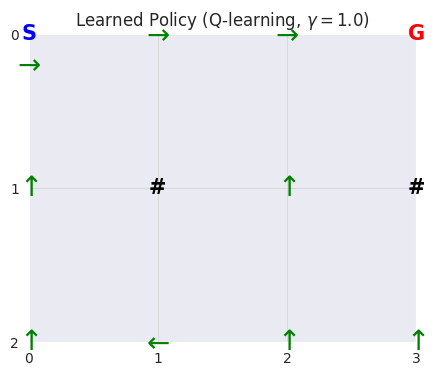

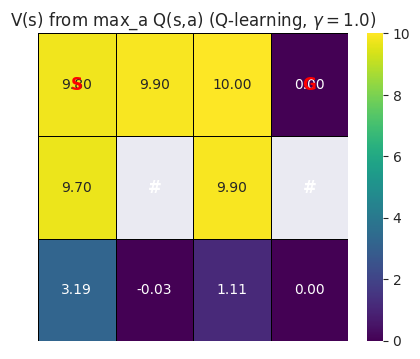

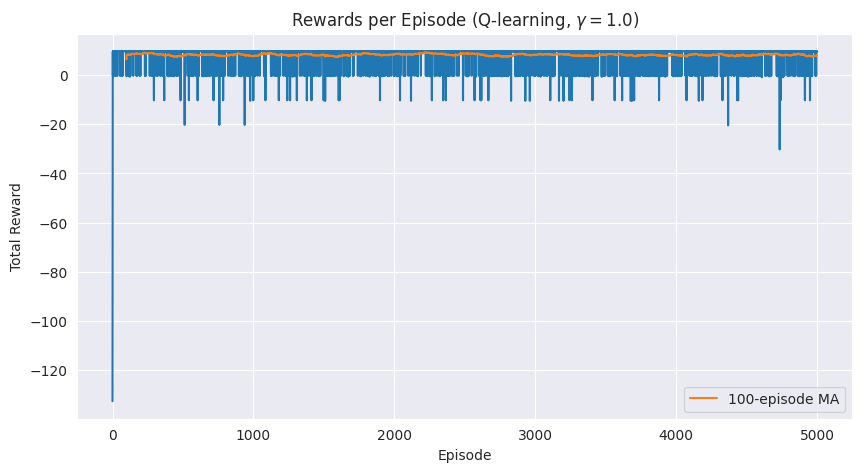

In [43]:
# Parameters for Q-learning with gamma = 1.0
q_gamma_1 = 1.0
q_alpha_1 = 0.1
q_epsilon_1 = 0.1
q_num_episodes_1 = 5000
q_max_steps_1 = 200

print(f"--- Running Q-learning for gamma = {q_gamma_1} ---")
Q_qlearn1, policy_qlearn1, rewards_qlearn1, V_qlearn1 = q_learning_control(
    maze_np, start_state, goal_state, action_names,
    q_gamma_1, q_alpha_1, q_epsilon_1, q_num_episodes_1, q_max_steps_1
)


plot_sarsa_policy(policy_qlearn1, title=rf"Learned Policy (Q-learning, $\gamma={q_gamma_1}$)")
plot_sarsa_value_function(V_qlearn1, title=rf"V(s) from max_a Q(s,a) (Q-learning, $\gamma={q_gamma_1}$)")
plot_episode_rewards(rewards_qlearn1, title=rf"Rewards per Episode (Q-learning, $\gamma={q_gamma_1}$)")

#  Results voor γ=1.0

### 1. Learned Policy & State Values (V(s)=maxa​Q(s,a)):
- De Policy plot laat zien dat Q-learning effectieve, grotendeels optimale paden naar ‘G’ heeft gevonden vanuit verschillende startpunten. Er kunnen kleine afwijkingen zijn in minder bezochte hoeken, maar de belangrijkste routes zijn duidelijk.
- De V(s)-heatmapwaarden liggen heel dicht bij het theoretische optimum voor γ=1,0. Langs het hoofdpad is V(S)(0,0) bijvoorbeeld 9,70 (theorie ~9,80), V(0,1) 9,90 (theorie 9,90) en V(0,2) 10,00 (theorie 10,00). Deze waarden liggen meestal iets dichter bij het echte optimum dan die van SARSA, wat komt door het off-policy gebruik van de max-operator in Q-learning. Alle haalbare states kregen waarde-updates door verkenning.

### 2. Rewards per Episode:
- De rewards plot laat zien dat het leren goed gaat: de rewards zijn snel gestegen vanaf de negatieve waarden in het begin en het voortschrijdend gemiddelde over 100 episodes is stabiel.
- De gemiddelde totale reward in de latere episode (8,35) is goed, maar iets lager dan de theoretische maximale path rewards (9,8) vanwege de voortdurende verkenning met ϵ=0,1. Deze prestatie is vergelijkbaar met die van SARSA.

### 3. Conclusie Q-learning (γ=1.0):
Q-learning heeft bijna de perfecte policy geleerd. De schattingen van de waarde van de states komen heel dicht in de buurt van de echte optimale waarden voor een taak zonder korting, wat laat zien hoe handig het is om de policy bij te werken. De prestaties van de agent zijn op een hoog niveau gestabiliseerd, vooral omdat er nog steeds meer moet worden ontdekt.



--- Running Q-learning for gamma = 0.9 ---
Episode 500/5000 completed. Avg reward (last 10%): 7.91
Episode 1000/5000 completed. Avg reward (last 10%): 8.48
Episode 1500/5000 completed. Avg reward (last 10%): 8.39
Episode 2000/5000 completed. Avg reward (last 10%): 8.40
Episode 2500/5000 completed. Avg reward (last 10%): 8.09
Episode 3000/5000 completed. Avg reward (last 10%): 8.26
Episode 3500/5000 completed. Avg reward (last 10%): 8.18
Episode 4000/5000 completed. Avg reward (last 10%): 8.56
Episode 4500/5000 completed. Avg reward (last 10%): 8.42
Episode 5000/5000 completed. Avg reward (last 10%): 8.58


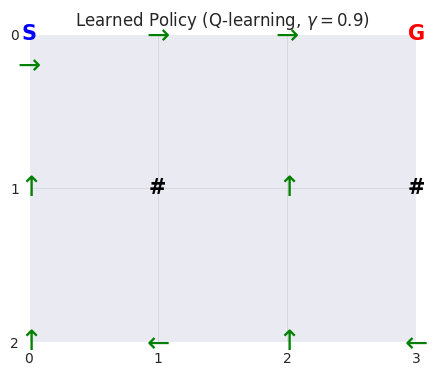

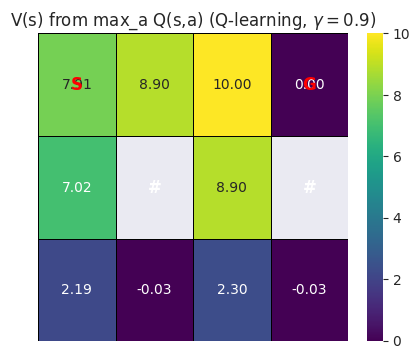

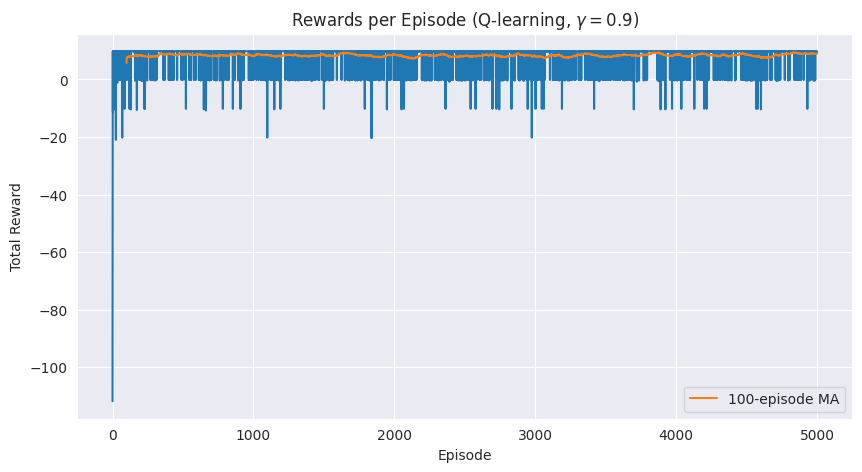

In [42]:
# Parameters for Q-learning with gamma = 0.9
q_gamma_2 = 0.9
q_alpha_2 = 0.1
q_epsilon_2 = 0.1
q_num_episodes_2 = 5000
q_max_steps_2 = 200

print(f"\n--- Running Q-learning for gamma = {q_gamma_2} ---")
Q_qlearn2, policy_qlearn2, rewards_qlearn2, V_qlearn2 = q_learning_control(
    maze_np, start_state, goal_state, action_names,
    q_gamma_2, q_alpha_2, q_epsilon_2, q_num_episodes_2, q_max_steps_2
)

# Use your plotting functions
plot_sarsa_policy(policy_qlearn2, title=rf"Learned Policy (Q-learning, $\gamma={q_gamma_2}$)")
plot_sarsa_value_function(V_qlearn2, title=rf"V(s) from max_a Q(s,a) (Q-learning, $\gamma={q_gamma_2}$)")
plot_episode_rewards(rewards_qlearn2, title=rf"Rewards per Episode (Q-learning, $\gamma={q_gamma_2}$)")

#  Results voor γ=0.9

### 1. Learned Policy & State Values
- De agent heeft een goede manier van werken geleerd, die er ongeveer hetzelfde uitziet als eerdere goede manieren en op sommige punten misschien nog wat beter is (bijvoorbeeld actie in state (2,3) was duidelijk LINKS).
- De waarden lieten een sterke korting zien: V(S) was 7,51 (tegenover 9,70 voor γ=1,0), terwijl V(0,1) 8,90 was en V(0,2) 10,00. Dit komt goed overeen met de theoretische berekeningen voor γ=0,9 met behulp van Q-learning's max update (bijvoorbeeld V(0,1) kwam perfect overeen met −0,1+0,9×V(0,2)).
- waarden waren over het algemeen dichter bij de optimale q∗​ in vergelijking met SARSA met γ=0,9.

### 2. Rewards per Episode:
- Een hoge gemiddelde beloning (8,58) gehaald, vergelijkbaar met of iets hoger dan andere succesvolle runs, wat een sterke prestatie laat zien.

### 3. Conclusie Q-learning (γ=0.9):
Q-learning met γ=0,9 vond effectief een optimaal policy en leerde actiewaarden die de discounted toekomstige rewards nauwkeurig weergeven, wat de sterke punten van deze methode als off-policy-methode bevestigt.
